# Extract Feature from Each Frame

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [2]:


# extract features from the CSV file
def extract_frame_features(frame_df, scaler=None):
    num_objects = len(frame_df)
    avg_conf = frame_df["confidence"].mean()
    avg_box_area = ((frame_df["x_max"] - frame_df["x_min"]) *
                    (frame_df["y_max"] - frame_df["y_min"])).mean()

    desired_size = 13
    class_counts = np.zeros(desired_size)

    for cls in frame_df["object_class"]:
        cls = int(cls)
        if cls < desired_size:
            class_counts[cls] += 1

    raw_features = [num_objects, avg_conf, avg_box_area] + class_counts.tolist()
    
    if scaler:
        raw_features = scaler.transform([raw_features])[0]  # normalize
    return torch.tensor(raw_features, dtype=torch.float32)


# Process the CSV file and extract features for each frame
def process_video_csv(csv_path, scaler = None):
    df = pd.read_csv(csv_path)

    sequences = []
    if "frame" not in df.columns or df.empty:
        return torch.empty(0, 16)  # return empty tensor with correct shape

    for _, frame_df in df.groupby("frame"):
        frame_feat = extract_frame_features(frame_df, scaler = scaler)
        sequences.append(frame_feat)

    if not sequences:
        return torch.empty(0, 16)  
    return torch.stack(sequences)




# Load Data Labels

In [3]:
import csv

# Load label CSV into a dictionary
label_dict = {}
with open("../../data/train_labels.csv", newline = "") as f:
    reader = csv.DictReader(f)
    for row in reader:
        label_dict[row["id"]] = int(row["target"])

# Split Data into Training, Validation, and Test Sets

In [4]:
from sklearn.model_selection import train_test_split

# Get all video directories
video_dirs = sorted([
    os.path.join("../../data/yolo_processed_data", d)
    for d in os.listdir("../../data/yolo_processed_data")
    if os.path.isdir(os.path.join("../../data/yolo_processed_data", d))
])

# Initialize an empty list to store video_ids
video_ids = []

# Extract video IDs from the directory names, removing video_ prefix
for video_dir in video_dirs:
    video_id = os.path.basename(video_dir).replace("video_", "")
    if video_id in label_dict:
        video_ids.append(video_id)
    else:
        raise AssertionError(f"Label missing for video: {video_id}")

# Split the video IDs
train_val_ids, test_ids = train_test_split(video_ids, test_size=0.2, random_state=42, stratify=[label_dict[vid] for vid in video_ids])

def get_video_dirs(ids):
    return [os.path.join("../../data/yolo_processed_data", "video_" + vid_id) for vid_id in ids]

train_val_dirs = get_video_dirs(train_val_ids)
test_dirs = get_video_dirs(test_ids)


In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(train_val_dirs))  # (train_idx, val_idx) for each fold

Before training, we need to compute the mean and standard deviation of each feature from the training set only.

# Create Dataset and DataLoader

In [6]:
# Create a dataset class for the video sequences
class VideoDataset(Dataset):
    def __init__(self, video_dirs, label_dict, scaler=None):
        self.video_dirs = video_dirs
        self.label_dict = label_dict
        self.scaler = scaler

    def __len__(self):
        return len(self.video_dirs)
    
    def __getitem__(self, idx):
        while True:
            video_dir = self.video_dirs[idx]
            video_id = os.path.basename(video_dir).replace("video_", "").zfill(5)
            label = self.label_dict.get(video_id, 0)

            csv_path = os.path.join(video_dir, "detections.csv")
            seq = process_video_csv(csv_path, scaler=self.scaler)

            if seq is None:
                idx = (idx + 1) % len(self.video_dirs)
                return self.__getitem__(idx)

            return seq, torch.tensor(label, dtype=torch.float32)
    
    
# Collate function to pad sequences and create batches
def collate_fn(batch):
    # Filter out samples with empty sequences
    batch = [(x, y) for x, y in batch if x.size(0) > 0]

    if len(batch) == 0:
        return None  # skip batch if empty

    batch.sort(key=lambda x: x[0].size(0), reverse=True)
    sequences, labels = zip(*batch)
    lengths = torch.tensor([seq.size(0) for seq in sequences])

    padded_seqs = pad_sequence(sequences, batch_first=True)
    labels = torch.stack(labels)

    return padded_seqs, lengths, labels



# # Create datasets for training and validation
# train_dataset = VideoDataset(train_videos, label_dict, scaler=feature_scaler)
# val_dataset = VideoDataset(val_videos, label_dict, scaler=feature_scaler)
# test_dataset = VideoDataset(test_videos, label_dict, scaler=feature_scaler)

# # Create DataLoader objects for training, validation, and testing
# train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True, collate_fn = collate_fn)
# val_loader = DataLoader(val_dataset, batch_size = 4, shuffle = False, collate_fn = collate_fn)
# test_loader = DataLoader(test_dataset, batch_size = 4, shuffle = False, collate_fn = collate_fn)

# Define the GRU Model

In [7]:
# Define the GRU model for classification
class GRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers = 2):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, dropout=0.2, batch_first = True, bidirectional = True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hn = self.gru(packed)  
        out = self.fc(hn[-1])     # Get last hidden state
        return self.sigmoid(out).squeeze()



# Training Loop

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fold_train_losses = []
fold_val_losses = []

for fold, (train_idx, val_idx) in enumerate(folds):
    print(f"\nFOLD {fold + 1}")

    train_dirs = [train_val_dirs[i] for i in train_idx]
    val_dirs = [train_val_dirs[i] for i in val_idx]

    # Build feature scaler from training data
    all_features = []
    for video_dir in train_dirs:
        for csv_file in sorted(os.listdir(video_dir)):
            if csv_file.endswith('.csv'):
                csv_path = os.path.join(video_dir, csv_file)
                df = pd.read_csv(csv_path)
                for _, frame_df in df.groupby("frame"):
                    features = extract_frame_features(frame_df, scaler=None)
                    if features.numel() > 0:
                        all_features.append(features.numpy())
    all_features = np.vstack(all_features)
    scaler = StandardScaler().fit(all_features)

    train_dataset = VideoDataset(train_dirs, label_dict, scaler)
    val_dataset = VideoDataset(val_dirs, label_dict, scaler)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

    model = GRUClassifier(input_dim=16, hidden_dim=128).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 10

    train_losses, val_losses = [], []

    for epoch in range(20):
        model.train()
        train_loss = 0
        for batch in train_loader:
            if batch is None:
                continue
            x_batch, lengths, y_batch = batch
            x_batch, lengths, y_batch = x_batch.to(device), lengths.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch, lengths)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        scheduler.step()
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1}, Loss: {avg_train_loss:.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                if batch is None:
                    continue
                x_batch, lengths, y_batch = batch
                x_batch, lengths, y_batch = x_batch.to(device), lengths.to(device), y_batch.to(device)

                outputs = model(x_batch, lengths)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'best_model_fold_{fold + 1}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)


FOLD 1
Epoch 1, Loss: 0.6895
Validation Loss: 0.6878
Epoch 2, Loss: 0.6754
Validation Loss: 0.6932
Epoch 3, Loss: 0.6682
Validation Loss: 0.6966
Epoch 4, Loss: 0.6611
Validation Loss: 0.7142
Epoch 5, Loss: 0.6563
Validation Loss: 0.7010
Epoch 6, Loss: 0.6409
Validation Loss: 0.7050
Epoch 7, Loss: 0.6130
Validation Loss: 0.7441
Epoch 8, Loss: 0.6026
Validation Loss: 0.7080
Epoch 9, Loss: 0.5672
Validation Loss: 0.7469
Epoch 10, Loss: 0.5340
Validation Loss: 0.7740
Epoch 11, Loss: 0.4831
Validation Loss: 0.8723
Early stopping triggered

FOLD 2
Epoch 1, Loss: 0.6978
Validation Loss: 0.6780
Epoch 2, Loss: 0.6740
Validation Loss: 0.6775
Epoch 3, Loss: 0.6791
Validation Loss: 0.6728
Epoch 4, Loss: 0.6777
Validation Loss: 0.6603
Epoch 5, Loss: 0.6823
Validation Loss: 0.6709
Epoch 6, Loss: 0.6586
Validation Loss: 0.6340
Epoch 7, Loss: 0.6450
Validation Loss: 0.6336
Epoch 8, Loss: 0.6362
Validation Loss: 0.6250
Epoch 9, Loss: 0.6307
Validation Loss: 0.6604
Epoch 10, Loss: 0.6064
Validation Los

In [18]:
# Build feature scaler from all train_val data
all_features = []
for video_dir in train_val_dirs:
    for csv_file in sorted(os.listdir(video_dir)):
        if csv_file.endswith('.csv'):
            csv_path = os.path.join(video_dir, csv_file)
            df = pd.read_csv(csv_path)
            for _, frame_df in df.groupby("frame"):
                features = extract_frame_features(frame_df, scaler=None)
                if features.numel() > 0:
                    all_features.append(features.numpy())

all_features = np.vstack(all_features)
test_scaler = StandardScaler().fit(all_features)

test_dataset = VideoDataset(test_dirs, label_dict, test_scaler)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

model = GRUClassifier(input_dim=16, hidden_dim=128).to(device)
model.load_state_dict(torch.load('best_model_fold_3.pth'))  # Example load
model.eval()

correct, total = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        if batch is None:
            continue
        x_batch, lengths, y_batch = batch
        x_batch, lengths, y_batch = x_batch.to(device), lengths.to(device), y_batch.to(device)
        preds = model(x_batch, lengths)
        predicted = (preds >= 0.5).float()
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

print(f"\nFinal Test Accuracy: {correct / total:.4f}")

/var/folders/sm/dt8s0j7j0glg1jfrlpndm0lw0000gn/T/ipykernel_18819/2643477537.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model


Final Test Accuracy: 0.6722


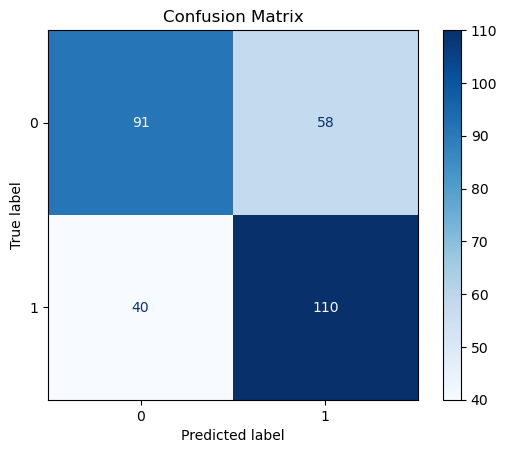

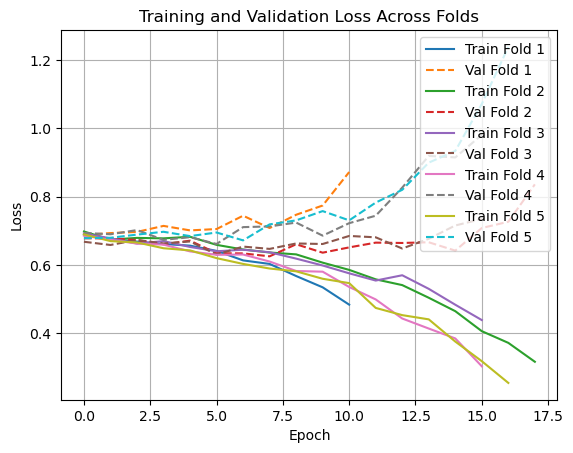

In [19]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot training and validation losses for each fold
for i, (train_losses, val_losses) in enumerate(zip(fold_train_losses, fold_val_losses)):
    plt.plot(train_losses, label=f'Train Fold {i+1}')
    plt.plot(val_losses, label=f'Val Fold {i+1}', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Folds')
plt.legend()
plt.grid(True)
plt.show()